In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# validation modules
import experiment
import metrics

# requires cleanair
sys.path.append("../containers")
from cleanair.models import ModelData

In [2]:
# read experiment from file
name = 'laptop_test'
cluster = 'laptop'
experiment_dir = '../run_model/experiments/'
exp = experiment.experiment_from_dir(name, cluster)

In [3]:
# load the data_model objects
secret_fp = "../terraform/.secrets/db_secrets.json"
model_data_list = []
for data_id in exp.experiment_df.data_id.unique():
    data_dir = experiment_dir + exp.name + '/data/data' + str(data_id)
    model_data = ModelData(config_dir=data_dir, secretfile=secret_fp)
    model_data_list.append(model_data)
    
    train_arrays = model_data.get_training_data_arrays()
    pred_arrays = model_data.get_pred_data_arrays()
    print('pred index:', pred_arrays['index'])
    print('train x shape:', train_arrays['X'].shape)
    print('pred x shape:', pred_arrays['X'].shape)
    print(model_data.normalised_pred_data_df.measurement_start_utc.unique())

pred index: Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            11654, 11655, 11656, 11657, 11658, 11659, 11660, 11661, 11662,
            11663],
           dtype='int64', length=10114)
train x shape: (6716, 4)
pred x shape: (10114, 4)
['2019-11-01 00:00:00' '2019-11-01 01:00:00' '2019-11-01 02:00:00'
 '2019-11-01 03:00:00' '2019-11-01 04:00:00' '2019-11-01 05:00:00'
 '2019-11-01 06:00:00' '2019-11-01 07:00:00' '2019-11-01 08:00:00'
 '2019-11-01 09:00:00' '2019-11-01 10:00:00' '2019-11-01 11:00:00'
 '2019-11-01 12:00:00' '2019-11-01 13:00:00' '2019-11-01 14:00:00'
 '2019-11-01 15:00:00' '2019-11-01 16:00:00' '2019-11-01 17:00:00'
 '2019-11-01 18:00:00' '2019-11-01 19:00:00' '2019-11-01 20:00:00'
 '2019-11-01 21:00:00' '2019-11-01 22:00:00' '2019-11-01 23:00:00'
 '2019-11-02 00:00:00' '2019-11-02 01:00:00' '2019-11-02 02:00:00'
 '2019-11-02 03:00:00' '2019-11-02 04:00:00' '2019-11-02 05:00:00'
 '2019-11-02 06:00:00' 

In [4]:
# get a list of model data objects with updated prediction columns
updated_preds = []


for index, row in exp.experiment_df.iterrows():
    row = exp.experiment_df.loc[index]
    pid = row['param_id']
    model = row['model_name']
    did = row['data_id']
#     y_test = np.load(exp.data_config[did]['y_test_fp'])
    Y_pred = np.load(row['y_pred_fp'])
    y_mean = Y_pred[0, :, 0]
    y_var = Y_pred[0, :, 1]
    
    # look at shapes
    data_config = exp.data_config[did]
    x_test = np.load(data_config['x_test_fp'])
    y_test = np.load(data_config['y_test_fp'])
    print("Xs :", x_test.shape)
    print("Ys :", y_test.shape)
    
    # update model_data
    normalised_df = model_data_list[did].normalised_pred_data_df.copy()
    print("normalised df shape:", normalised_df.shape)
    
    gb = normalised_df.dropna(axis=1).groupby(['measurement_start_utc', 'point_id'])
#     print(gb.filter(lambda x: x['lat'].count() == 4).count())
    
    predict_data_dict = model_data_list[did].get_pred_data_arrays(dropna=True).copy()
    print('pred data dict x', predict_data_dict['X'].shape)
    
    # Create new dataframe with predictions
    predict_df = pd.DataFrame(index=predict_data_dict['index'])
    print("Pred index shape:", predict_df.shape)
    print("Y pred shape:", Y_pred.shape)
    print("Y mean shape:", np.reshape(y_mean, y_mean.shape[0]).shape)
    print("Y var shape:", y_var.shape)
    predict_df['predict_mean'] = np.reshape(y_mean, y_mean.shape[0])
    predict_df['predict_var'] = np.reshape(y_var, y_var.shape[0])
    predict_df['fit_start_time'] = exp.data_config[did]['pred_start_date']
    predict_df['tag'] = 0
    
    normalised_pred_data_df = pd.concat([model_data_list[did].normalised_pred_data_df, predict_df], axis=1, ignore_index=False)
    updated_preds.append(normalised_pred_data_df)


Xs : (10114, 4)
Ys : (10114, 1)
normalised df shape: (11664, 20)
pred data dict x (10114, 4)
Pred index shape: (10114, 0)
Y pred shape: (1, 10114, 2)
Y mean shape: (10114,)
Y var shape: (10114,)
Xs : (10109, 4)
Ys : (10109, 1)
normalised df shape: (11664, 20)
pred data dict x (10109, 4)
Pred index shape: (10109, 0)
Y pred shape: (1, 10109, 2)
Y mean shape: (10109,)
Y var shape: (10109,)
Xs : (10114, 4)
Ys : (10114, 1)
normalised df shape: (11664, 20)
pred data dict x (10114, 4)
Pred index shape: (10114, 0)
Y pred shape: (1, 10114, 2)
Y mean shape: (10114,)
Y var shape: (10114,)
Xs : (10109, 4)
Ys : (10109, 1)
normalised df shape: (11664, 20)
pred data dict x (10109, 4)
Pred index shape: (10109, 0)
Y pred shape: (1, 10109, 2)
Y mean shape: (10109,)
Y var shape: (10109,)


In [9]:
i = 3
preds = updated_preds[i]
preds['measurement_start_utc'] = pd.to_datetime(preds['measurement_start_utc'])
gb = preds.groupby('point_id')
print(preds.columns)

Index(['Unnamed: 0', 'point_id', 'measurement_start_utc', 'source', 'location',
       'lon', 'lat', 'date_opened', 'date_closed', 'value_1000_flat',
       'value_500_flat', 'value_200_flat', 'value_100_flat', 'value_10_flat',
       'epoch', 'NO2', 'epoch_norm', 'lat_norm', 'lon_norm',
       'value_1000_flat_norm', 'predict_mean', 'predict_var', 'fit_start_time',
       'tag'],
      dtype='object')


In [18]:
def plot_pretty_timeseries(time, series, ax, sigmas=None, locator=dates.DayLocator(interval=1)):
    ax.plot_date(time, series, ',', linestyle='-')
    ax.xaxis.grid(True, which="major")
#     ax.xaxis.set_major_locator(locator)
#     ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%m'))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H\n%d'))
    
    if not sigmas is None:
        factor = 2
        y_min = series - factor*np.sqrt(sigmas)
        y_max = series + factor*np.sqrt(sigmas)
        ax.fill_between(time, y_min, y_max, color='orange', alpha=0.5)
        
        
    return ax

times: (288,)
means: (288,)
sigmas: (288,)


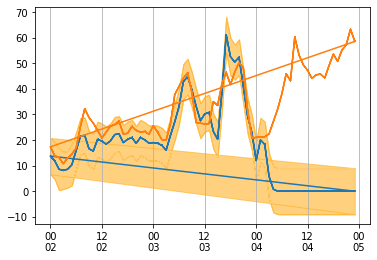

times: (72,)
means: (72,)
sigmas: (72,)


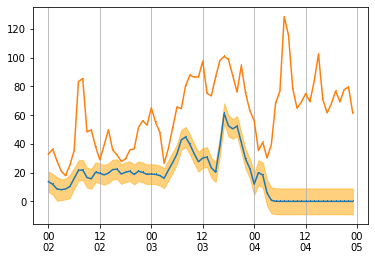

times: (72,)
means: (72,)
sigmas: (72,)


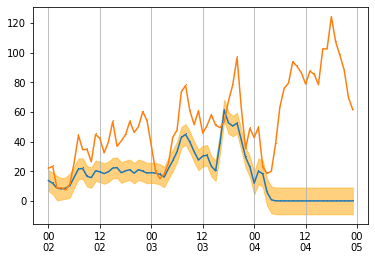

times: (72,)
means: (72,)
sigmas: (72,)


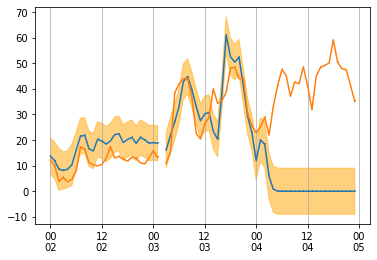

times: (72,)
means: (72,)
sigmas: (72,)


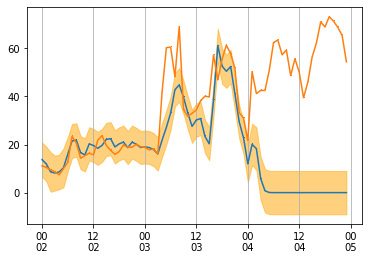

times: (72,)
means: (72,)
sigmas: (72,)


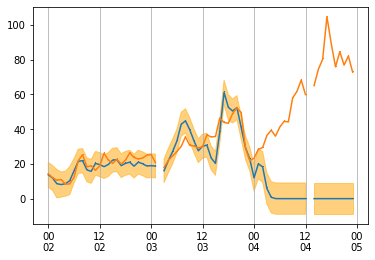

times: (72,)
means: (72,)
sigmas: (72,)


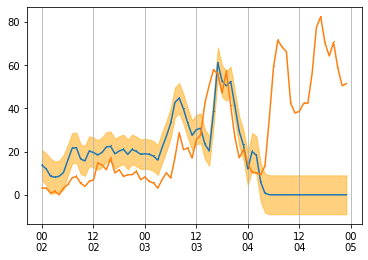

times: (72,)
means: (72,)
sigmas: (72,)


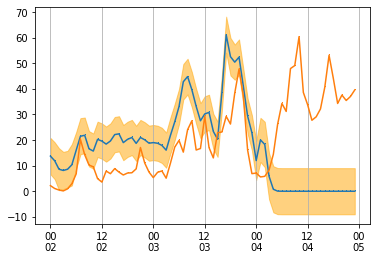

times: (72,)
means: (72,)
sigmas: (72,)


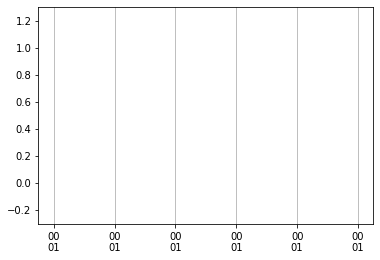

times: (72,)
means: (72,)
sigmas: (72,)


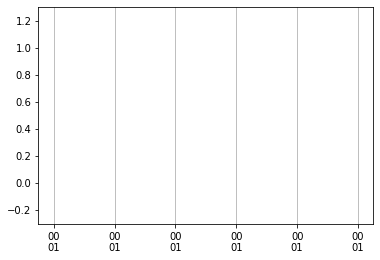

times: (72,)
means: (72,)
sigmas: (72,)


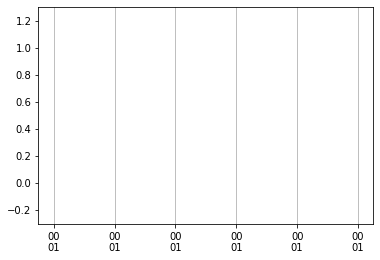

In [19]:
count = 0
for point, row in gb:
    fig0, ax = plt.subplots()
    times = row['measurement_start_utc']
    means = row['predict_mean']
    sigmas = row['predict_var']
    print("times:", times.shape)
    print("means:", means.shape)
    print("sigmas:", sigmas.shape)
    locator = dates.HourLocator(interval=6)
    plot_pretty_timeseries(times, means, ax, sigmas=sigmas, locator=locator)
    plot_pretty_timeseries(times, row['NO2'], ax, locator=locator)
    plt.show()
    count += 1
    if count > 10:
        break

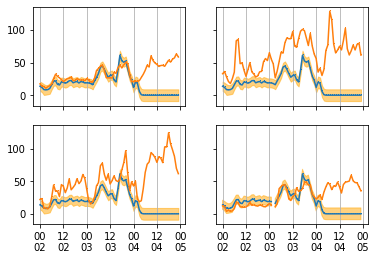

In [20]:
n = 2 # number of rows
c = 2 # number of columns
fig, axs = plt.subplots(n, c, sharex=True, sharey=True)
i = 0
j = 0
for point, point_df in gb:
    point_df = point_df.sort_values(by='measurement_start_utc')
    plot_pretty_timeseries(point_df['measurement_start_utc'], point_df['predict_mean'], axs[i, j], sigmas=point_df['predict_var'], locator=dates.HourLocator(interval=6))
    plot_pretty_timeseries(point_df['measurement_start_utc'], point_df['NO2'], axs[i, j], locator=dates.HourLocator(interval=6))
    i += j % c
    j += 1
    j = j % c
    if i == n:
        break